In [1]:
import pandas as pd

In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from kobert_tokenizer import KoBERTTokenizer
import gluonnlp as nlp
import numpy as np
import re
import matplotlib.pyplot as plt


In [3]:
#region 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer.tokenize

#device = torch.device("cpu")
device = torch.device("cuda:0")

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6, #클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         
    def __len__(self):
        return (len(self.labels))
    
model_path = '../sentiment-analysis/model/kobert-v6.pt'
#model_path = 'sentiment-analysis/model/kobert-v6.pt' #(cmd 위치 기준)
model = torch.load(model_path)
#model = model.to('cpu')

max_len = 64
batch_size = 64

#예측함수
def predict(sentence):
    dataset = [[sentence, '0']]
    test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=0)
    model.eval()
    answer = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        for logits in out:
            logits = logits.detach().cpu().numpy()
            answer = np.argmax(logits)
    return answer
#endregion


def runKobert(title, raw_file):
    raw_text = ''
    
    if raw_file[-4:]=='html':
        print("html 문서읽기")
        with open(raw_file, 'r', encoding='utf-8') as html_file:
            raw_text = html_file.read()
    
    else: 
        print("txt 문서읽기")
        file = open(raw_file, 'r',encoding='UTF8')    #인코딩 안바꾸면 오류
        raw_text = file.readlines()
            
    textsum = '' 
    if isinstance(raw_text, list):
        #줄바꿈제거
        for sentence in raw_text:
            sentence = sentence.replace("\n", "")
            textsum += sentence
    else:
        textsum=raw_text
        
    print("textsum",len(textsum))
        
    #(한자) 제거    
    textsum = re.sub('\([^)]*\)|[一-龥]', '', textsum)
            
    #문장 단위로 분리: . ”로 끝날때마다 묶어주기
    text = []
    s, e = 0, 0
    isopen = False #쌍따옴표 안에 글자인지 확인
    for i in range(len(textsum)-1):
        if textsum[i]=='“':
            isopen = True
            continue
            
        if (textsum[i]=='.' and textsum[i+1]!='”' and isopen==False) or textsum[i]=='”':
            e = i+1
            text.append(textsum[s:e].strip())
            s = e
            isopen = False
            
    print(len(text),"문장 감성분석 시작")

                    
    # #csv파일 생성, 쓰기
    # with open(r'C:\Users\KangIW\Desktop\output.csv', 'w', newline='', encoding="utf-8-sig") as f:
    #     writer = csv.writer(f)
    #     for item in text:
    #         writer.writerow([item])
        
    
    #데이터프레임으로
    df = pd.DataFrame(text, columns=['sentence'])
    
    emos = ('행복','불안·공포','놀람', '슬픔','분노','중립')
    res = {'행복':0,'불안·공포':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}

    for index, data in df.iterrows():
        res[emos[predict(data['sentence'])]] += 1
    print(res)
    
    #del res['중립'] #중립 태그 제거

    # 키와 값 리스트 추출
    labels = list(res.keys())
    sizes = list(res.values())
      
    #region 원형 그래프 그리기
    fig1, ax1 = plt.subplots()
    #fig1.set_size_inches(6, 6)  # 그래프 크기 설정


    # 가운데 부분을 뚤린 원형으로 설정
    wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성
    
    # 원형 그래프 그리기
    outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
    inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=outer_colors, wedgeprops=wedgeprops)

    ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})  # 가운데 뚤린 원형 추가

    # 가운데 부분에 텍스트 추가
    plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)
    
    # 제목, 그래프랑 간격
    plt.title(title, fontweight='bold', fontsize=16)
    plt.subplots_adjust(top=1.2)

    # 가운데 뚤린 원형 그래프 출력
    plt.axis('equal')
    plt.show()
    #endregion

    # res_copied = res.copy()
    # del res_copied['중립']
    # del res_copied['놀람']
    # res_emo = max(res_copied, key=res_copied.get)

    # # print(res_emo)
    # return res_emo

In [7]:
import matplotlib.font_manager as fm

fontpath = r'C:\Windows\Fonts\H2GTRE.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)
print(plt.rcParams['font.family']) #적용됬는지 확인

['HYGothic-Extra']


txt 문서읽기
textsum 21861
495 문장 감성분석 시작
{'행복': 16, '불안·공포': 20, '놀람': 59, '슬픔': 61, '분노': 22, '중립': 317}


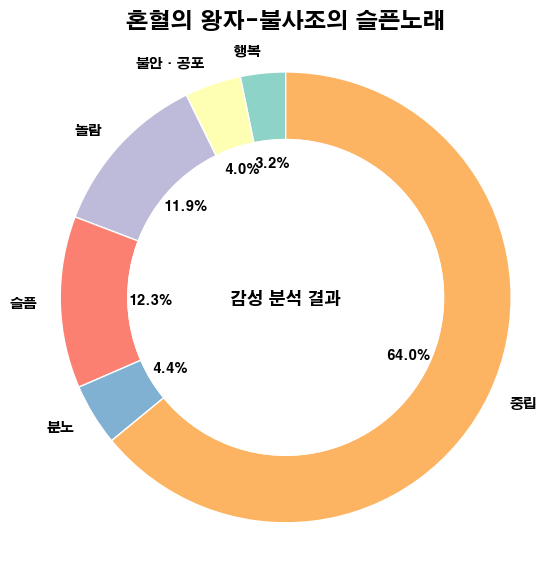

In [58]:
file_path = 'C:/Users/KangIW/Desktop/혼혈의왕자_불사조의슬픈노래_.txt'

runKobert("혼혈의 왕자-불사조의 슬픈노래",file_path)

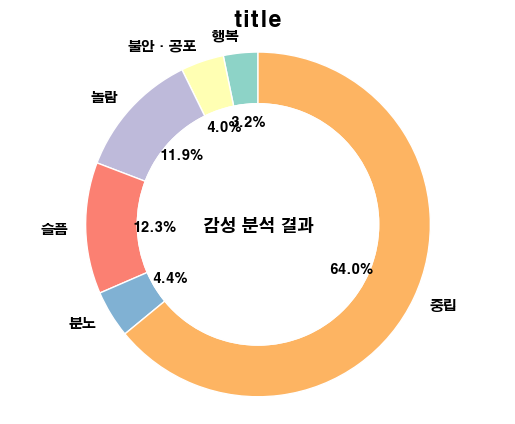

In [8]:
res = {'행복': 16, '불안·공포': 20, '놀람': 59, '슬픔': 61, '분노': 22, '중립': 317}

# 키와 값 리스트 추출
labels = list(res.keys())
sizes = list(res.values())

# 원형 그래프 그리기
fig1, ax1 = plt.subplots()

# 가운데 부분을 뚤린 원형으로 설정
wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

# 원형 그래프 그리기
outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=outer_colors, wedgeprops=wedgeprops)

ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops, textprops={'fontsize': 14})  # 가운데 뚤린 원형 추가

# 가운데 부분에 텍스트 추가
plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)

# 제목, 그래프랑 간격
plt.title("title", fontweight='bold', fontsize=16)
plt.subplots_adjust(top=0.9)

# 가운데 뚤린 원형 그래프 출력
plt.axis('equal')
plt.show()

txt 문서읽기
textsum 21861
495 문장 감성분석 시작
{'행복': 16, '불안': 20, '놀람': 59, '슬픔': 61, '분노': 22, '중립': 317}


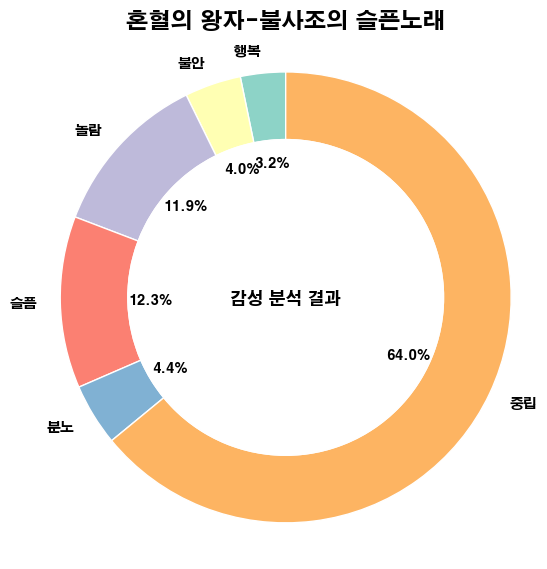

In [56]:
file_path = 'C:/Users/KangIW/Desktop/혼혈의왕자_불사조의슬픈노래_.txt'
runKobert("혼혈의 왕자-불사조의 슬픈노래",file_path)

txt 문서읽기
textsum 1978
76 문장 감성분석 시작
{'행복': 1, '불안·공포': 0, '놀람': 2, '슬픔': 3, '분노': 6, '중립': 64}


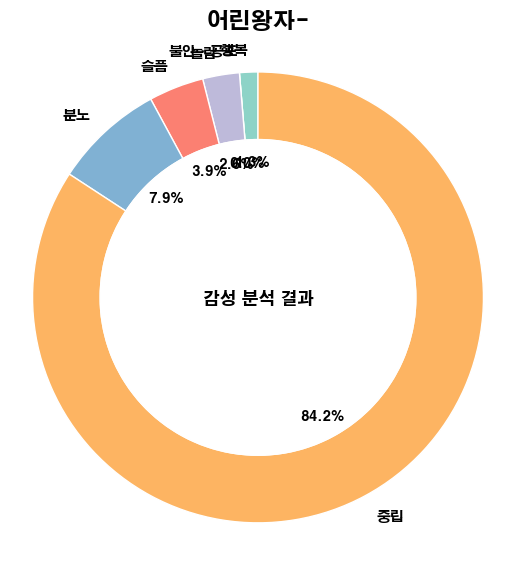

In [60]:
file_path = 'C:/Users/KangIW/Desktop/어린왕자-.txt'
runKobert("어린왕자-",file_path)

txt 문서읽기
textsum 18995
592 문장 감성분석 시작
{'행복': 29, '불안·공포': 20, '놀람': 28, '슬픔': 55, '분노': 44, '중립': 416}


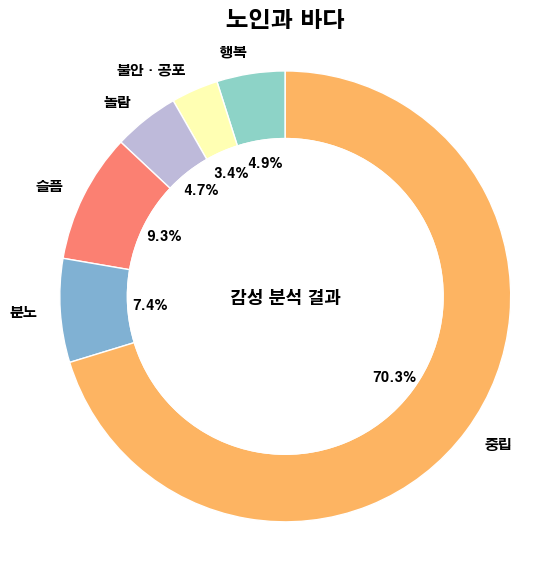

In [62]:
file_path = 'C:/Users/KangIW/Desktop/노인과 바다.txt'
runKobert("노인과 바다",file_path)

txt 문서읽기
textsum 9593
238 문장 감성분석 시작
{'행복': 43, '불안·공포': 2, '놀람': 14, '슬픔': 27, '분노': 6, '중립': 146}


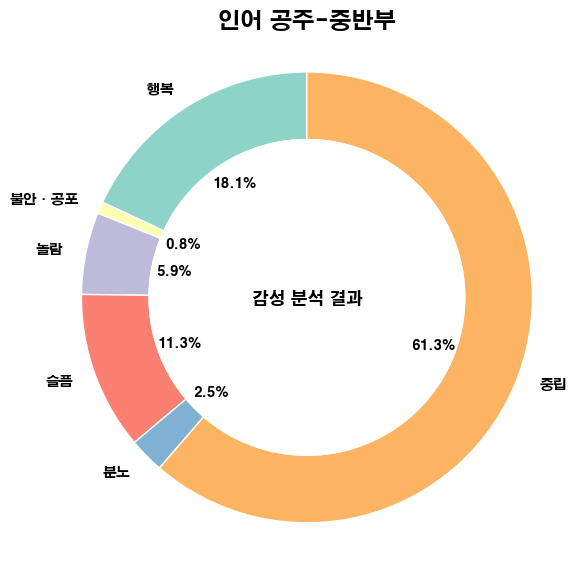

In [9]:
file_path = 'C:/Users/KangIW/Desktop/인어_공주.txt'
runKobert("인어 공주-중반부",file_path)

txt 문서읽기
textsum 93443
2318 문장 감성분석 시작
{'행복': 124, '불안·공포': 51, '놀람': 131, '슬픔': 319, '분노': 112, '중립': 1581}


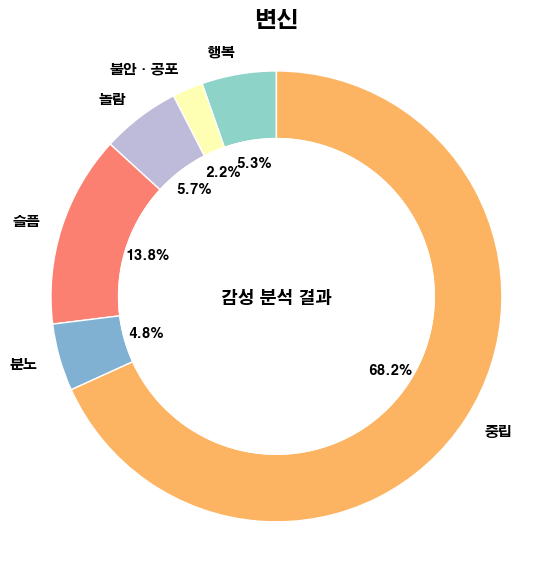

In [10]:
file_path = 'C:/Users/KangIW/Desktop/변신.txt'
runKobert("변신",file_path)